In [1]:
import json
import csv
from pathlib import Path

# Define file paths
judge_path = Path('/home/xinding/dingxin/Agent/MAIA/evaluation/MAIA/judge_scores.json')
model_path = Path('/home/xinding/dingxin/Agent/MAIA/evaluation/MAIA/model_answers.json')
qa_path = Path('/home/xinding/dingxin/Agent/MAIA/benchmark/MAIA_reasoning.json')

In [4]:
import json
from pathlib import Path

# 文件路径
judge_path = Path('/home/xinding/dingxin/Agent/MAIA/evaluation/MAIA/judge_scores.json')
qa_path = Path('/home/xinding/dingxin/Agent/MAIA/benchmark/MAIA_reasoning.json')
output_path = Path('low_score_qa.json')

# 1. 加载评分
with open(judge_path, 'r', encoding='utf-8') as f:
    judge_scores = json.load(f)

# 2. 加载 QA 数据（列表）
with open(qa_path, 'r', encoding='utf-8') as f:
    qa_list = json.load(f)

# 3. 筛选评分 <= 4 的 QA 对（基于顺序索引）
filtered_qa = []
for i, qa in enumerate(qa_list):
    score_info = judge_scores.get(str(i), {})
    if isinstance(score_info, dict) and score_info.get("score", 5) <= 4:
        filtered_qa.append(qa)

# 4. 保存筛选结果
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(filtered_qa, f, ensure_ascii=False, indent=2)

print(f"✅ 筛选完成：共 {len(filtered_qa)} 条得分≤4 的 QA 对，已保存至 {output_path.resolve()}")


✅ 筛选完成：共 713 条得分≤4 的 QA 对，已保存至 /home/xinding/dingxin/Agent/MAIA/code/low_score_qa.json


In [5]:
import json
import random
from pathlib import Path

# ---------------- 路径 ----------------
judge_path  = Path("/home/xinding/dingxin/Agent/MAIA/evaluation/MAIA/judge_scores.json")
qa_path     = Path("/home/xinding/dingxin/Agent/MAIA/benchmark/MAIA_reasoning.json")
output_path = Path("diagnostic_pathway_score5_201.json")

# 固定随机种子，确保可复现
random.seed(42)

# ---------------- 读取文件 ----------------
with open(judge_path, "r", encoding="utf-8") as f:
    judge_scores = json.load(f)            # dict: {index_str: {"score": ..}}

with open(qa_path, "r", encoding="utf-8") as f:
    qa_list = json.load(f)                 # list

# ---------------- 过滤 ----------------
diag_score5 = [
    qa
    for i, qa in enumerate(qa_list)
    if qa.get("type") == "diagnostic_pathway"
       and isinstance(judge_scores.get(str(i)), dict)
       and judge_scores[str(i)].get("score") == 5
]

# ---------------- 抽样 ----------------
if len(diag_score5) >= 201:
    selected = random.sample(diag_score5, 201)
else:
    selected = diag_score5
    print(f"⚠️  仅找到 {len(selected)} 条满足条件的题目，已全部保留。")

# ---------------- 保存 ----------------
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(selected, f, ensure_ascii=False, indent=2)

print(f"✅ 完成！共 {len(selected)} 条 diagnostic_pathway 且得分=5 的题目写入 {output_path.resolve()}")


✅ 完成！共 201 条 diagnostic_pathway 且得分=5 的题目写入 /home/xinding/dingxin/Agent/MAIA/code/diagnostic_pathway_score5_201.json


In [6]:
import json
from collections import Counter
from pathlib import Path

# 加载 QA 数据
qa_path = Path('low_score_qa.json')
with open(qa_path, 'r', encoding='utf-8') as f:
    qa_list = json.load(f)  # 是一个 list

# 统计 type 字段
type_counter = Counter()
for item in qa_list:
    qtype = item.get("type", "UNKNOWN")
    type_counter[qtype] += 1

# 打印统计结果
print("📊 各类型问题统计：")
for t, count in type_counter.items():
    print(f"{t}: {count}")


📊 各类型问题统计：
kg_reasoning: 466
diagnostic_pathway: 247


In [3]:
import json
import random

# ---------- 参数 ----------
SEED = 42                                  # 固定随机种子，方便复现
IN_FILE = "../benchmark/MAIA.json"                      # 原始数据
OUT_FILE = "MAIA_retrieval100.json"        # 抽样结果
# ---------- 抽样配额（方案 B） ----------
N_PUBMED = 33
N_CT = 33
N_OT_DISEASE = 15
N_OT_SAFETY = 4
N_OT_TRACT = 15
# ---------------------------

random.seed(SEED)

# 1) 读文件
with open(IN_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)
retrieval = data[:471]          # 前 471 条

# 2) 切分五段
pubmed       = retrieval[0:100]
clinical     = retrieval[100:200]
ot_disease   = retrieval[200:319]          # 119
ot_safety    = retrieval[319:350]          # 31
ot_tract     = retrieval[350:471]          # 121

# 3) 抽样
sample = (
      random.sample(pubmed, N_PUBMED)
    + random.sample(clinical, N_CT)
    + random.sample(ot_disease, N_OT_DISEASE)
    + random.sample(ot_safety, N_OT_SAFETY)
    + random.sample(ot_tract, N_OT_TRACT)
)
random.shuffle(sample)                     # 可选：打乱顺序

# 4) 写文件
with open(OUT_FILE, "w", encoding="utf-8") as f:
    json.dump(sample, f, ensure_ascii=False, indent=2)

print(f"✅  Done: {len(sample)} questions saved to {OUT_FILE}")


✅  Done: 100 questions saved to MAIA_retrieval100.json


In [ ]:
import json
import random
from pathlib import Path

# ----------- 配置 -----------
FILES = [
    "MAIA_retrieval100.json",
    "low_score_qa.json",
    "diagnostic_pathway_score5_201.json",
]
OUT_FILE = "MAIA_final_merged.json"
SEED = 42               # 如要保持顺序可设为 None
# ---------------------------

def load_dataset(path: Path):
    """兼容两种格式：dict(dataset=[]) 或直接list"""
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, dict) and "dataset" in data:
        return data["dataset"]
    elif isinstance(data, list):
        return data
    else:
        raise ValueError(f"{path} 不是支持的格式")

# 1) 读取并合并
merged = []
for p in FILES:
    items = load_dataset(Path(p))
    merged.extend(items)
print(f"合并后共有 {len(merged)} 条")

# 2) 可选：根据 id 去重
seen = set()
deduped = []
for qa in merged:
    qa_id = qa.get("id")
    if qa_id and qa_id not in seen:
        seen.add(qa_id)
        deduped.append(qa)
print(f"去重后共有 {len(deduped)} 条")

# 3) 可选：随机打乱
if SEED is not None:
    random.Random(SEED).shuffle(deduped)

# 4) 保存
with Path(OUT_FILE).open("w", encoding="utf-8") as f:
    json.dump({"dataset": deduped}, f, ensure_ascii=False, indent=2)

print(f"✅ 已写入 {OUT_FILE}（{len(deduped)} 条）")


In [8]:
import json, random
from pathlib import Path

# ---------------- 配置 ----------------
FILES = {
    "retrieval": "MAIA_retrieval100.json",
    "low_score": "low_score_qa.json",
    "diag201":   "diagnostic_pathway_score5_201.json",
}
OUT_FILE = "MAIA_final_sorted.json"
SEED = 42          # 设为 None 可得到真正随机顺序
# -------------------------------------

def load_ds(path: str):
    """兼容 {"dataset": [...]} 或直接 list"""
    with Path(path).open("r", encoding="utf-8") as f:
        data = json.load(f)
    return data["dataset"] if isinstance(data, dict) else data

# 1) 读取各文件
retrieval_set   = load_ds(FILES["retrieval"])
low_score_set   = load_ds(FILES["low_score"])
diag201_set     = load_ds(FILES["diag201"])

# 2) 从 low_score 拆出两类
kg_reasoning, diag_from_low = [], []
for qa in low_score_set:
    t = qa.get("type")
    if t == "kg_reasoning":
        kg_reasoning.append(qa)
    elif t == "diagnostic_pathway":
        diag_from_low.append(qa)

# 3) 合并 diagnostic_pathway：低分版 + 201 满分版
diagnostic_pathway = diag_from_low + diag201_set

# 4) 可复现打乱各块内部顺序
rng = random.Random(SEED) if SEED is not None else random
for block in (retrieval_set, kg_reasoning, diagnostic_pathway):
    rng.shuffle(block)

# 5) 拼接并去重
merged, seen = [], set()
for block in (retrieval_set, kg_reasoning, diagnostic_pathway):
    for qa in block:
        _id = qa.get("id")
        if _id not in seen:
            merged.append(qa)
            seen.add(_id)

# 6) 写文件
with Path(OUT_FILE).open("w", encoding="utf-8") as f:
    json.dump(merged, f, ensure_ascii=False, indent=2)

print("✅ 完成！")
print(f"  retrieval           {len(retrieval_set)}")
print(f"  kg_reasoning (≤4)   {len(kg_reasoning)}")
print(f"  diagnostic_pathway  {len(diagnostic_pathway)}")
print(f"👉 合并去重后总数      {len(merged)}   已写入 {Path(OUT_FILE).resolve()}")


✅ 完成！
  retrieval           100
  kg_reasoning (≤4)   466
  diagnostic_pathway  448
👉 合并去重后总数      1014   已写入 /home/xinding/dingxin/Agent/MAIA/code/MAIA_final_sorted.json


In [9]:
import json, random
from pathlib import Path

# ---------- 输入文件 ----------
PATH_RETRIEVAL = "MAIA_retrieval100.json"
PATH_LOW_SCORE = "low_score_qa.json"
PATH_DIAG201   = "diagnostic_pathway_score5_201.json"

OUT_FILE = "MAIA_final_shuffled.json"
SEED = 42          # 设为 None => 真正随机

# ---------- 读取工具 ----------
def load_ds(fp):
    with Path(fp).open("r", encoding="utf-8") as f:
        data = json.load(f)
    return data["dataset"] if isinstance(data, dict) else data

# ---------- 合并 ----------
merged = (
      load_ds(PATH_RETRIEVAL)
    + load_ds(PATH_LOW_SCORE)
    + load_ds(PATH_DIAG201)
)

# ---------- 去重按 id ----------
uniq, seen = [], set()
for qa in merged:
    qid = qa.get("id")
    if qid not in seen:
        uniq.append(qa)
        seen.add(qid)

# ---------- 完全打乱 ----------
rng = random.Random(SEED) if SEED is not None else random
rng.shuffle(uniq)

# ---------- 保存 ----------
with Path(OUT_FILE).open("w", encoding="utf-8") as f:
    json.dump({"dataset": uniq}, f, ensure_ascii=False, indent=2)

print(f"✅ 完成！已写入 {Path(OUT_FILE).resolve()}  |  总计 {len(uniq)} 条")


✅ 完成！已写入 /home/xinding/dingxin/Agent/MAIA/code/MAIA_final_shuffled.json  |  总计 1014 条


In [ ]:
import json, random
from pathlib import Path
import os
os.environ["OPENAI_API_KEY"] = 'sk-4jnd9yjoIXnQRQ5SXR2b3bVO1d3sHtuyegGMzAl6awSWDRNn' 
os.environ['OPENAI_BASE_URL'] = 'https://api2.aigcbest.top/v1' 

# os.environ["OPENAI_API_KEY"] = 'sk-OlimLcefr3MBSt08IrcZ9LrhP94qqni4w3u4qkOPFtAULcDD' 
# os.environ['OPENAI_BASE_URL'] = 'https://api.chatanywhere.tech' 

os.environ["AZURE_OPENAI_API_KEY"] = "5a1437f6ff2648b9b969507fb5a73276"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ai-mistraleastus2753718354821.openai.azure.com/"
# ========== 输入文件 ==========
PATH_LOW_SCORE = "low_score_qa.json"                  # ≤4 分推理题
PATH_DIAG201   = "diagnostic_pathway_score5_201.json" # 201 条满分诊疗路径

OUT_FILE = "MAIA_reasoning_shuffled.json"
SEED = 42               # 固定随机种子；设为 None 可每次不同

# ---------- 工具 ----------
def load_dataset(fp: str):
    """兼容 {"dataset":[...]} 或直接 list"""
    with Path(fp).open("r", encoding="utf-8") as f:
        data = json.load(f)
    return data["dataset"] if isinstance(data, dict) else data

# ---------- 读取 ----------
low_score_set = load_dataset(PATH_LOW_SCORE)
diag201_set   = load_dataset(PATH_DIAG201)

# ---------- 合并并按 id 去重 ----------
merged, seen = [], set()
for qa in low_score_set + diag201_set:
    qid = qa.get("id")
    if qid not in seen:
        merged.append(qa)
        seen.add(qid)

print(f"合并后去重共 {len(merged)} 条")

# ---------- 打乱顺序 ----------
rng = random.Random(SEED) if SEED is not None else random
rng.shuffle(merged)

# ---------- 保存 ----------
with Path(OUT_FILE).open("w", encoding="utf-8") as f:
    json.dump({"dataset": merged}, f, ensure_ascii=False, indent=2)

print(f"✅ 已写入 {Path(OUT_FILE).resolve()} (随机顺序)")


合并后去重共 914 条
✅ 已写入 /home/xinding/dingxin/Agent/MAIA/code/MAIA_reasoning_shuffled.json (随机顺序)


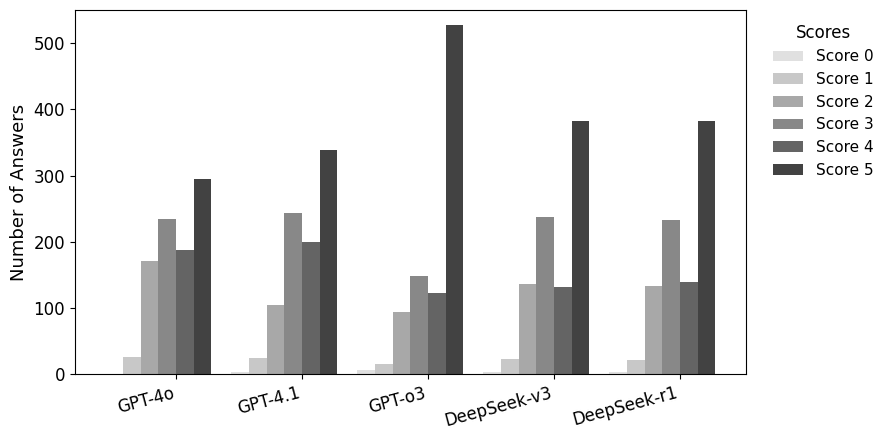

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Percentage score distribution data
data = {
    'Model': ['GPT-4o', 'GPT-4.1', 'GPT-o3', 'DeepSeek-v3', 'DeepSeek-r1'],
    '0':  [1,3,6,4,3],
    '1':  [26,25,15,23,22],
    '2':  [171,105,94,136,134],
    '3':  [234,244,148,237,233],
    '4':  [187,199,123,132,139],
    '5':  [295,338,527,382,383],
}

df = pd.DataFrame(data)

models = df['Model']
scores = ['0', '1', '2', '3', '4', '5']
n_scores = len(scores)
bar_width = 0.14

indices = np.arange(len(models))

gray_colors = ['#e0e0e0', '#c8c8c8', '#a8a8a8', '#888888', '#646464', '#424242']

fig, ax = plt.subplots(figsize=(9, 4.5))

for i, score in enumerate(scores):
    offsets = indices - (n_scores/2 - i + 0.5) * bar_width
    ax.bar(offsets, df[score], bar_width, label=f'Score {score}', color=gray_colors[i])

# 字体放大部分
ax.set_xticks(indices)
ax.set_xticklabels(models, rotation=15, ha='right', fontsize=12)
ax.set_ylabel('Number of Answers', fontsize=13)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.set_ylim(0, 550)
ax.legend(title='Scores', fontsize=11, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()



In [2]:
# Save as PDF (vector graphic) & PNG
pdf_path = 'score_distribution.pdf'
png_path = 'score_distribution.png'
fig.savefig(pdf_path, bbox_inches='tight')
fig.savefig(png_path, dpi=300, bbox_inches='tight')

pdf_path, png_path

('score_distribution.pdf', 'score_distribution.png')

In [8]:
# prefix_completion_test.py
# prefix_completion_test_100.py
import os, json, difflib, argparse
from collections import defaultdict
from pathlib import Path

import tiktoken
import pandas as pd
from tqdm import tqdm              # 进度条
from rouge_score import rouge_scorer
from openai import AzureOpenAI
os.environ["OPENAI_API_KEY"] = 'sk-4jnd9yjoIXnQRQ5SXR2b3bVO1d3sHtuyegGMzAl6awSWDRNn' 
os.environ['OPENAI_BASE_URL'] = 'https://api2.aigcbest.top/v1' 

# os.environ["OPENAI_API_KEY"] = 'sk-OlimLcefr3MBSt08IrcZ9LrhP94qqni4w3u4qkOPFtAULcDD' 
# os.environ['OPENAI_BASE_URL'] = 'https://api.chatanywhere.tech' 

os.environ["AZURE_OPENAI_API_KEY"] = "5a1437f6ff2648b9b969507fb5a73276"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ai-mistraleastus2753718354821.openai.azure.com/"
# ---------- 参数 ----------
JSON_PATH      = "../dataset/MAIA.json"   # ← 按需修改
MODEL_NAME     = "gpt-4.1-noah"
PREFIX_RATIO   = 0.5
MAX_TOKENS_GEN = 128

# ---------- 编码与分段 ----------
enc = tiktoken.encoding_for_model("gpt-4o-mini")
def prefix_by_ratio(text, ratio=PREFIX_RATIO):
    toks = enc.encode(text)
    k = max(1, int(len(toks) * ratio))
    return enc.decode(toks[:k]), enc.decode(toks[k:])

# ---------- Azure OpenAI 客户端 ----------
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-12-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

def complete(prefix: str) -> str:
    prompt = f"继续补全下面医学问题的剩余部分，仅输出补全内容，不要重复前缀：\n\n{prefix}"
    rsp = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=MAX_TOKENS_GEN,
        temperature=0.0)
    return rsp.choices[0].message.content.strip()

# ---------- 读取数据 ----------
with open(JSON_PATH, encoding="utf-8") as f:
    dataset = json.load(f)["dataset"]

# ---------- 迭代 100 条并统计 ----------
scorer  = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
results = defaultdict(list)

for item in tqdm(dataset[:100], desc="Prefix-completion test"):
    qid   = item["id"]
    full  = item["question"]
    pref, gold = prefix_by_ratio(full)

    try:
        gen = complete(pref)
    except Exception as e:
        print(f"[{qid}] API error → {e}")
        continue

    rougeL = scorer.score(gold, gen)["rougeL"].fmeasure
    lev    = difflib.SequenceMatcher(None, gold, gen).ratio()

    results["qid"].append(qid)
    results["rougeL"].append(rougeL)
    results["levsim"].append(lev)

    tqdm.write(f"{qid:>18} | rougeL={rougeL:.3f} | lev_sim={lev:.3f}")

# ---------- 汇总输出 ----------
df = pd.DataFrame(results)
print("\n=== 统计（前 100 条）===")
display(df.describe())          # 在 Notebook 中更友好；脚本环境可换成 print(df.describe())

Prefix-completion test:   1%|          | 1/100 [00:02<04:27,  2.70s/it]

 path_fff39451d940 | rougeL=0.040 | lev_sim=0.036


Prefix-completion test:   2%|▏         | 2/100 [00:04<03:22,  2.07s/it]

 path_3223e4eadd22 | rougeL=0.144 | lev_sim=0.035


Prefix-completion test:   3%|▎         | 3/100 [00:05<02:42,  1.67s/it]

 path_976765c010fc | rougeL=0.100 | lev_sim=0.201


Prefix-completion test:   4%|▍         | 4/100 [00:07<02:34,  1.61s/it]

   kg_56e0201f800c | rougeL=0.189 | lev_sim=0.013


Prefix-completion test:   5%|▌         | 5/100 [00:09<03:00,  1.90s/it]

 path_1fd4016b0eb3 | rougeL=0.113 | lev_sim=0.019


Prefix-completion test:   6%|▌         | 6/100 [00:11<03:07,  2.00s/it]

   kg_de46fbf2e081 | rougeL=0.068 | lev_sim=0.034


Prefix-completion test:   7%|▋         | 7/100 [00:13<02:50,  1.83s/it]

 path_13f5b98449a9 | rougeL=0.109 | lev_sim=0.000


Prefix-completion test:   8%|▊         | 8/100 [00:14<02:24,  1.57s/it]

 path_66570ee9ee65 | rougeL=0.462 | lev_sim=0.574


Prefix-completion test:   9%|▉         | 9/100 [00:16<02:36,  1.72s/it]

  ret_7cf1c006af64 | rougeL=0.000 | lev_sim=0.044


Prefix-completion test:  10%|█         | 10/100 [00:17<02:27,  1.64s/it]

 path_8677599bbd68 | rougeL=0.147 | lev_sim=0.130


Prefix-completion test:  11%|█         | 11/100 [00:18<02:11,  1.47s/it]

 path_89c651146801 | rougeL=0.182 | lev_sim=0.166


Prefix-completion test:  12%|█▏        | 12/100 [00:20<02:27,  1.67s/it]

   kg_6cea24422376 | rougeL=0.167 | lev_sim=0.080


Prefix-completion test:  13%|█▎        | 13/100 [00:22<02:19,  1.61s/it]

   kg_f99ad791f0e4 | rougeL=0.074 | lev_sim=0.026


Prefix-completion test:  14%|█▍        | 14/100 [00:23<02:01,  1.41s/it]

 path_54fbe177e9bb | rougeL=0.129 | lev_sim=0.123


Prefix-completion test:  15%|█▌        | 15/100 [00:24<01:51,  1.31s/it]

   kg_31569021267f | rougeL=0.114 | lev_sim=0.107


Prefix-completion test:  16%|█▌        | 16/100 [00:25<01:55,  1.37s/it]

 path_0b68ced3a6fe | rougeL=0.111 | lev_sim=0.032


Prefix-completion test:  17%|█▋        | 17/100 [00:28<02:28,  1.79s/it]

  ret_919801a7f240 | rougeL=0.020 | lev_sim=0.017


Prefix-completion test:  18%|█▊        | 18/100 [00:29<02:06,  1.54s/it]

   kg_2ac12625293f | rougeL=0.160 | lev_sim=0.019


Prefix-completion test:  19%|█▉        | 19/100 [00:30<01:49,  1.35s/it]

 path_78e4510698c9 | rougeL=0.143 | lev_sim=0.328


Prefix-completion test:  20%|██        | 20/100 [00:31<01:44,  1.30s/it]

 path_338f0153e203 | rougeL=0.297 | lev_sim=0.055


Prefix-completion test:  21%|██        | 21/100 [00:32<01:31,  1.16s/it]

 path_3d7e36df50e1 | rougeL=0.087 | lev_sim=0.321


Prefix-completion test:  22%|██▏       | 22/100 [00:33<01:33,  1.20s/it]

   kg_d0aaf7181848 | rougeL=0.202 | lev_sim=0.052


Prefix-completion test:  23%|██▎       | 23/100 [00:36<01:55,  1.50s/it]

 path_26a7ad9cab41 | rougeL=0.180 | lev_sim=0.146


Prefix-completion test:  24%|██▍       | 24/100 [00:37<02:04,  1.64s/it]

   kg_877d6ed93fc7 | rougeL=0.136 | lev_sim=0.070


Prefix-completion test:  25%|██▌       | 25/100 [00:40<02:21,  1.88s/it]

  ret_693e88983b13 | rougeL=0.049 | lev_sim=0.024


Prefix-completion test:  26%|██▌       | 26/100 [00:41<02:05,  1.70s/it]

  ret_8b33291b3cef | rougeL=0.130 | lev_sim=0.314


Prefix-completion test:  27%|██▋       | 27/100 [00:43<02:08,  1.76s/it]

   kg_0f7217bb043e | rougeL=0.168 | lev_sim=0.058


Prefix-completion test:  28%|██▊       | 28/100 [00:45<02:03,  1.71s/it]

   kg_1000c155efe1 | rougeL=0.145 | lev_sim=0.069


Prefix-completion test:  29%|██▉       | 29/100 [00:46<01:58,  1.66s/it]

   kg_6cd25f151dd1 | rougeL=0.171 | lev_sim=0.069


Prefix-completion test:  30%|███       | 30/100 [00:47<01:40,  1.43s/it]

  ret_f03c2ec6a19e | rougeL=0.143 | lev_sim=0.245


Prefix-completion test:  31%|███       | 31/100 [00:49<01:42,  1.48s/it]

   kg_4b693854e03a | rougeL=0.124 | lev_sim=0.043


Prefix-completion test:  32%|███▏      | 32/100 [00:51<01:46,  1.56s/it]

 path_bb00926f5398 | rougeL=0.170 | lev_sim=0.292


Prefix-completion test:  33%|███▎      | 33/100 [00:52<01:39,  1.49s/it]

   kg_59ff004fc69c | rougeL=0.178 | lev_sim=0.080


Prefix-completion test:  34%|███▍      | 34/100 [00:53<01:22,  1.25s/it]

 path_9bbd3f608c64 | rougeL=0.150 | lev_sim=0.371


Prefix-completion test:  35%|███▌      | 35/100 [00:54<01:20,  1.24s/it]

  ret_eec158176b55 | rougeL=0.231 | lev_sim=0.297


Prefix-completion test:  36%|███▌      | 36/100 [00:54<01:07,  1.06s/it]

 path_3f75a1a8cca9 | rougeL=0.111 | lev_sim=0.219


Prefix-completion test:  37%|███▋      | 37/100 [00:57<01:29,  1.42s/it]

  ret_16a04d7adba0 | rougeL=0.076 | lev_sim=0.073


Prefix-completion test:  38%|███▊      | 38/100 [00:58<01:25,  1.38s/it]

   kg_f5e0c8b143e5 | rougeL=0.080 | lev_sim=0.197


Prefix-completion test:  39%|███▉      | 39/100 [00:59<01:17,  1.26s/it]

 path_75163c7f02b1 | rougeL=0.222 | lev_sim=0.236


Prefix-completion test:  40%|████      | 40/100 [01:01<01:22,  1.38s/it]

 path_50517b538924 | rougeL=0.255 | lev_sim=0.139


Prefix-completion test:  41%|████      | 41/100 [01:02<01:17,  1.31s/it]

   kg_146c98caebc6 | rougeL=0.212 | lev_sim=0.013


Prefix-completion test:  42%|████▏     | 42/100 [01:03<01:17,  1.33s/it]

   kg_879fb41534fd | rougeL=0.176 | lev_sim=0.071


Prefix-completion test:  43%|████▎     | 43/100 [01:05<01:20,  1.40s/it]

   kg_7aefd06b58ae | rougeL=0.167 | lev_sim=0.016


Prefix-completion test:  44%|████▍     | 44/100 [01:07<01:33,  1.68s/it]

   kg_14d83ffb9d24 | rougeL=0.179 | lev_sim=0.086


Prefix-completion test:  45%|████▌     | 45/100 [01:08<01:22,  1.50s/it]

 path_2373666236c2 | rougeL=0.143 | lev_sim=0.096


Prefix-completion test:  46%|████▌     | 46/100 [01:09<01:17,  1.43s/it]

   kg_a192f535092a | rougeL=0.086 | lev_sim=0.049


Prefix-completion test:  47%|████▋     | 47/100 [01:11<01:18,  1.47s/it]

 path_1bef3b99e7ad | rougeL=0.108 | lev_sim=0.045


Prefix-completion test:  48%|████▊     | 48/100 [01:12<01:10,  1.36s/it]

   kg_62890e8291cb | rougeL=0.174 | lev_sim=0.012


Prefix-completion test:  49%|████▉     | 49/100 [01:13<01:02,  1.22s/it]

   kg_17de39478c39 | rougeL=0.107 | lev_sim=0.173


Prefix-completion test:  50%|█████     | 50/100 [01:14<01:01,  1.24s/it]

   kg_2286dad272ae | rougeL=0.140 | lev_sim=0.023


Prefix-completion test:  51%|█████     | 51/100 [01:16<01:10,  1.44s/it]

   kg_015880f59105 | rougeL=0.150 | lev_sim=0.041


Prefix-completion test:  52%|█████▏    | 52/100 [01:17<01:06,  1.39s/it]

   kg_22f645bd9b3d | rougeL=0.200 | lev_sim=0.075


Prefix-completion test:  53%|█████▎    | 53/100 [01:18<00:59,  1.28s/it]

   kg_5312df554a6a | rougeL=0.026 | lev_sim=0.067


Prefix-completion test:  54%|█████▍    | 54/100 [01:20<01:03,  1.37s/it]

   kg_592fe3c89172 | rougeL=0.086 | lev_sim=0.022


Prefix-completion test:  55%|█████▌    | 55/100 [01:21<00:52,  1.18s/it]

 path_8fc762be7760 | rougeL=0.227 | lev_sim=0.464


Prefix-completion test:  56%|█████▌    | 56/100 [01:22<00:50,  1.15s/it]

   kg_1efacb709f17 | rougeL=0.175 | lev_sim=0.063


Prefix-completion test:  57%|█████▋    | 57/100 [01:23<00:50,  1.17s/it]

   kg_7b44633aa7e8 | rougeL=0.145 | lev_sim=0.024


Prefix-completion test:  58%|█████▊    | 58/100 [01:25<01:00,  1.44s/it]

 path_ef1cf930bc18 | rougeL=0.107 | lev_sim=0.019


Prefix-completion test:  59%|█████▉    | 59/100 [01:26<00:58,  1.44s/it]

   kg_3fd8328d7d1e | rougeL=0.089 | lev_sim=0.022


Prefix-completion test:  60%|██████    | 60/100 [01:28<00:57,  1.44s/it]

   kg_c1dcedc85aaf | rougeL=0.079 | lev_sim=0.091


Prefix-completion test:  61%|██████    | 61/100 [01:30<00:59,  1.51s/it]

 path_735b711ec4d7 | rougeL=0.117 | lev_sim=0.007


Prefix-completion test:  62%|██████▏   | 62/100 [01:31<01:00,  1.58s/it]

 path_a93e91d7f81b | rougeL=0.185 | lev_sim=0.206


Prefix-completion test:  63%|██████▎   | 63/100 [01:33<00:58,  1.58s/it]

 path_22b34b1ece73 | rougeL=0.144 | lev_sim=0.097


Prefix-completion test:  64%|██████▍   | 64/100 [01:34<00:55,  1.55s/it]

   kg_37c0be1d9051 | rougeL=0.127 | lev_sim=0.036


Prefix-completion test:  65%|██████▌   | 65/100 [01:36<00:53,  1.53s/it]

 path_f15e06aa3494 | rougeL=0.224 | lev_sim=0.104


Prefix-completion test:  66%|██████▌   | 66/100 [01:37<00:51,  1.53s/it]

   kg_8cbc64f6bca9 | rougeL=0.148 | lev_sim=0.025


Prefix-completion test:  67%|██████▋   | 67/100 [01:38<00:43,  1.32s/it]

 path_9c2d09957799 | rougeL=0.188 | lev_sim=0.027


Prefix-completion test:  68%|██████▊   | 68/100 [01:40<00:47,  1.50s/it]

   kg_0a6f79e37fbd | rougeL=0.100 | lev_sim=0.070


Prefix-completion test:  69%|██████▉   | 69/100 [01:41<00:44,  1.44s/it]

 path_bd5caad93235 | rougeL=0.077 | lev_sim=0.047


Prefix-completion test:  70%|███████   | 70/100 [01:44<00:55,  1.86s/it]

 path_6010c50cdd2e | rougeL=0.093 | lev_sim=0.005


Prefix-completion test:  71%|███████   | 71/100 [01:45<00:45,  1.56s/it]

 path_40ba96328dae | rougeL=0.127 | lev_sim=0.043


Prefix-completion test:  72%|███████▏  | 72/100 [01:47<00:42,  1.53s/it]

 path_3d863626ef35 | rougeL=0.180 | lev_sim=0.119


Prefix-completion test:  73%|███████▎  | 73/100 [01:49<00:46,  1.71s/it]

 path_ee2e402077ad | rougeL=0.114 | lev_sim=0.028


Prefix-completion test:  74%|███████▍  | 74/100 [01:50<00:43,  1.69s/it]

   kg_806edc19efb3 | rougeL=0.115 | lev_sim=0.044


Prefix-completion test:  75%|███████▌  | 75/100 [01:52<00:39,  1.57s/it]

   kg_474ba465454f | rougeL=0.208 | lev_sim=0.372


Prefix-completion test:  76%|███████▌  | 76/100 [01:53<00:32,  1.36s/it]

 path_6c74e23e8ba9 | rougeL=0.189 | lev_sim=0.333


Prefix-completion test:  77%|███████▋  | 77/100 [01:54<00:30,  1.35s/it]

   kg_a46b095e7fa1 | rougeL=0.133 | lev_sim=0.003


Prefix-completion test:  78%|███████▊  | 78/100 [01:56<00:34,  1.59s/it]

   kg_3a9190fa1d17 | rougeL=0.105 | lev_sim=0.037


Prefix-completion test:  79%|███████▉  | 79/100 [01:57<00:32,  1.54s/it]

 path_2282759c3b2f | rougeL=0.129 | lev_sim=0.129


Prefix-completion test:  80%|████████  | 80/100 [01:59<00:33,  1.67s/it]

  ret_66c55daa66f2 | rougeL=0.101 | lev_sim=0.025


Prefix-completion test:  81%|████████  | 81/100 [02:01<00:31,  1.68s/it]

 path_683f88394ba4 | rougeL=0.097 | lev_sim=0.020


Prefix-completion test:  82%|████████▏ | 82/100 [02:02<00:27,  1.55s/it]

  ret_4afe92a42dc6 | rougeL=0.129 | lev_sim=0.365


Prefix-completion test:  83%|████████▎ | 83/100 [02:04<00:28,  1.66s/it]

  ret_8b35d8bcf123 | rougeL=0.340 | lev_sim=0.495


Prefix-completion test:  84%|████████▍ | 84/100 [02:05<00:22,  1.41s/it]

   kg_107a55685bbe | rougeL=0.246 | lev_sim=0.149


Prefix-completion test:  85%|████████▌ | 85/100 [02:07<00:23,  1.55s/it]

 path_c88b06ac825a | rougeL=0.133 | lev_sim=0.047


Prefix-completion test:  86%|████████▌ | 86/100 [02:08<00:21,  1.53s/it]

 path_53812c268bc6 | rougeL=0.110 | lev_sim=0.018


Prefix-completion test:  87%|████████▋ | 87/100 [02:09<00:17,  1.36s/it]

 path_2215b19f0054 | rougeL=0.235 | lev_sim=0.137


Prefix-completion test:  88%|████████▊ | 88/100 [02:11<00:16,  1.34s/it]

   kg_dca8fef6a8c9 | rougeL=0.123 | lev_sim=0.017


Prefix-completion test:  89%|████████▉ | 89/100 [02:12<00:13,  1.27s/it]

   kg_05e96f2c7984 | rougeL=0.208 | lev_sim=0.173


Prefix-completion test:  90%|█████████ | 90/100 [02:14<00:15,  1.59s/it]

   kg_8e79c446c0d5 | rougeL=0.104 | lev_sim=0.037


Prefix-completion test:  91%|█████████ | 91/100 [02:16<00:14,  1.57s/it]

  ret_149ae23e6028 | rougeL=0.079 | lev_sim=0.035


Prefix-completion test:  92%|█████████▏| 92/100 [02:18<00:14,  1.84s/it]

   kg_00a94a802fbc | rougeL=0.109 | lev_sim=0.033


Prefix-completion test:  93%|█████████▎| 93/100 [02:20<00:12,  1.73s/it]

 path_117837ecca97 | rougeL=0.119 | lev_sim=0.033


Prefix-completion test:  94%|█████████▍| 94/100 [02:21<00:10,  1.71s/it]

   kg_9729e96312d3 | rougeL=0.131 | lev_sim=0.096


Prefix-completion test:  95%|█████████▌| 95/100 [02:23<00:09,  1.84s/it]

   kg_2510ca2306b6 | rougeL=0.151 | lev_sim=0.069


Prefix-completion test:  96%|█████████▌| 96/100 [02:25<00:06,  1.70s/it]

   kg_ae104372548f | rougeL=0.097 | lev_sim=0.013


Prefix-completion test:  97%|█████████▋| 97/100 [02:26<00:04,  1.63s/it]

   kg_bb0f784b8c8d | rougeL=0.113 | lev_sim=0.050


Prefix-completion test:  98%|█████████▊| 98/100 [02:28<00:03,  1.80s/it]

 path_aa294a369042 | rougeL=0.121 | lev_sim=0.045


Prefix-completion test:  99%|█████████▉| 99/100 [02:30<00:01,  1.78s/it]

 path_8166df2370f5 | rougeL=0.103 | lev_sim=0.014


Prefix-completion test: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]

 path_85494f985b90 | rougeL=0.175 | lev_sim=0.048

=== 统计（前 100 条）===


,rougeL,levsim
count,100.000000,100.000000
mean,0.142803,0.104742
std,0.064596,0.118744
min,0.000000,0.000000
25%,0.106316,0.026467
50%,0.132087,0.053347
75%,0.175535,0.131733
max,0.461538,0.573770


In [1]:
import json

# 读取原始 MAIA.json 文件
with open('../MAIA/MAIA.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 提取 type 为 retrieval 的条目
retrieval_entries = [entry for entry in data.get('dataset', []) if entry.get('type') == 'retrieval']

# 构建新的 JSON 对象
retrieval_data = {
    "dataset": retrieval_entries
}

# 保存为新的 JSON 文件
with open('../MAIA/MAIA_retrieval.json', 'w', encoding='utf-8') as f:
    json.dump(retrieval_data, f, ensure_ascii=False, indent=2)

print(f"提取完成，共提取 {len(retrieval_entries)} 条 retrieval 类型问题。")


提取完成，共提取 100 条 retrieval 类型问题。
